In [1]:
#imports
import shap
from keras import layers, models
from keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt 
import pickle

In [ ]:
#initialize dataset
(trainingListsData, trainingLabels) , (testListsData, testLabels) = imdb.load_data()
#inverted dictionary (to get the words associated with the index)
wordDictionary = dict( (i + 3, word) for (word, i) in imdb.get_word_index().items() )

#set true for debug output
if (False):
    #prints data from first review
    print(trainingLists[0])
    #prints translated words from first review
    for i in range(25):
        print(wordDictionary.get(trainingLists[0][i]))

#reconstruct the dataset (each review is an array of how often a word appeared, instead of a list of the words)

#set true for demonstration output
if (False):
    histogrammFirstReview = np.histogram(trainingListsData[0], bins = 10000, range = (1, 10000))[0]
    print(histogrammFirstReview[0:100])
    plt.bar(np.arange(0, 100), histogrammFirstReview[0:100], width = 1, align = "edge")

imdbDataRaw = np.concatenate((trainingListsData, testListsData), axis = 0)
imdbLabels = np.concatenate((trainingLabels, testLabels), axis = 0)
print(len(imdbDataRaw))

counter = 0
trainingLists = np.histogram(imdbDataRaw[0], bins = 1000, range = (1, 10000))[0]
for review in imdbDataRaw[1:]:
    trainingLists = np.vstack((trainingLists, np.histogram(review, bins = 1000, range = (1, 10000))[0] ))
    counter += 1
    print(str(counter) + " " + str(counter/50000 * 100) + "%")

print(np.shape(trainingLists))

np.save("HistogramData", trainingLists)
np.save("Labels", imdbLabels)


In [2]:
#load modified (histogram) data
data = np.load("HistogramData.npy")
labels = np.load("Labels.npy")

print(np.shape(data))
print(np.shape(labels))

testData = data[:10000]
testLabels = labels[:10000]
trainData = data[10000:]
trainLabels = labels[10000:]

(50000, 1000)
(50000,)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               100100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 105671 (412.78 KB)
Trainable params: 1056

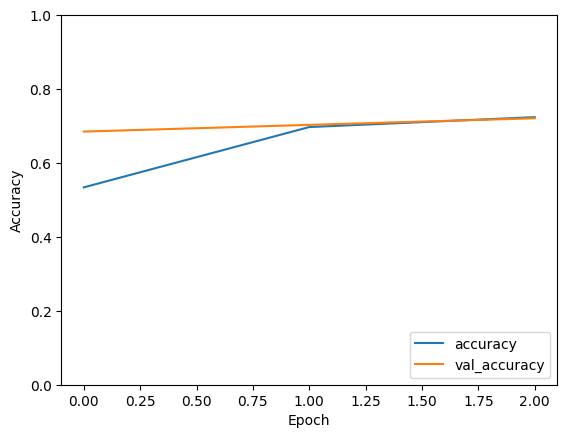

313/313 - 0s - loss: 0.5526 - accuracy: 0.7209 - 224ms/epoch - 714us/step
0.7208999991416931


In [3]:
#define the model

model = models.Sequential()
#alternate dense connected layers for learning and dropout to prevent overfitting
model.add(layers.Dense(100, activation = "relu", input_shape=(1000, )))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(50, activation = "relu"))
model.add(layers.Dropout(0.30))
model.add(layers.Dense(10, activation = "relu"))
# Output-Layer
model.add(layers.Dense(1, activation = "sigmoid"))
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(trainData, trainLabels, epochs=3, validation_data=(testData, testLabels))

#set to True to display the changing accuracy of the model during training
if(True):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

#display the accuracy of the trained model
test_loss, test_acc = model.evaluate(testData,  testLabels, verbose=2)
print(test_acc)

In [ ]:
#getting the SHAP values

#creating a masker (a permutated dataset to train the explainer on)
masker = shap.maskers.Independent(data = trainData)
#create the explainer and get the shap-values
explainer = shap.explainers.Permutation(model, masker = masker, max_evals = 2000)
shapValues = explainer(trainData[:10000])

print(type(shapValues))

In [17]:
#store the Shap Values
with open("ShapValues.pkl", "wb") as file:
    pickle.dump(shapValues, file)

In [4]:
#load the Shap-Values
with open("ShapValues.pkl", "rb") as file:
    shapValues = pickle.load(file)

print(type(shapValues))
print(shapValues)

<class 'shap._explanation.Explanation'>
.values =
array([[-8.67236388e-02, -1.67139010e-02, -2.61187199e-02, ...,
         1.10739991e-04,  0.00000000e+00, -3.88517976e-05],
       [-1.56309769e-01, -9.24435116e-02, -1.39031580e-02, ...,
         2.71166041e-04,  0.00000000e+00, -1.98549032e-05],
       [-8.05345647e-02, -6.70906041e-03, -5.77694781e-03, ...,
        -6.17995858e-06,  0.00000000e+00,  9.43511724e-06],
       ...,
       [-7.86745429e-02, -2.42505259e-02, -6.24495186e-03, ...,
         1.63141936e-04,  0.00000000e+00, -8.27968121e-06],
       [ 2.22807587e-01,  4.36154270e-02,  4.91337908e-02, ...,
         9.04917717e-05,  0.00000000e+00, -9.59753990e-06],
       [ 2.69940078e-01,  8.82703193e-03,  2.24603713e-03, ...,
        -4.11279500e-05,  0.00000000e+00, -4.04149294e-06]])

.base_values =
array([[0.5459378],
       [0.5459378],
       [0.5459378],
       ...,
       [0.5459378],
       [0.5459378],
       [0.5459378]])

.data =
array([[ 25,  16,   5, ...,   0,   

(inputs, Features)
(10000, 1000)


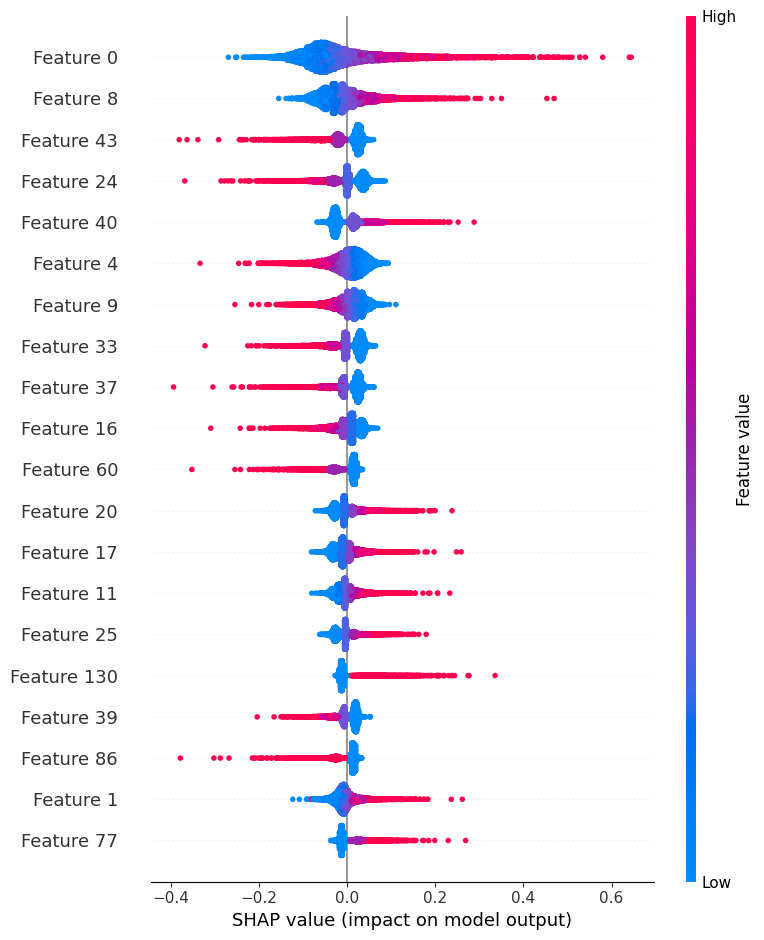

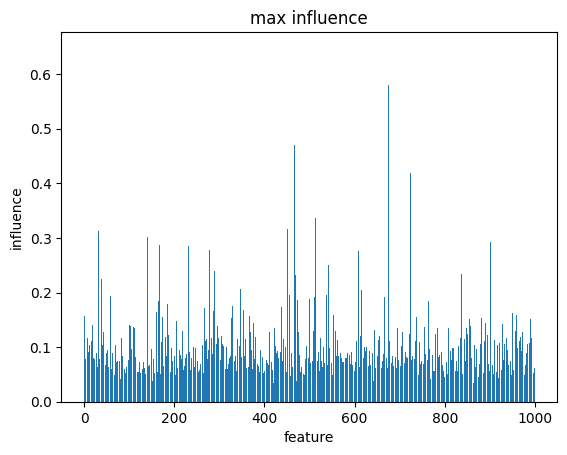

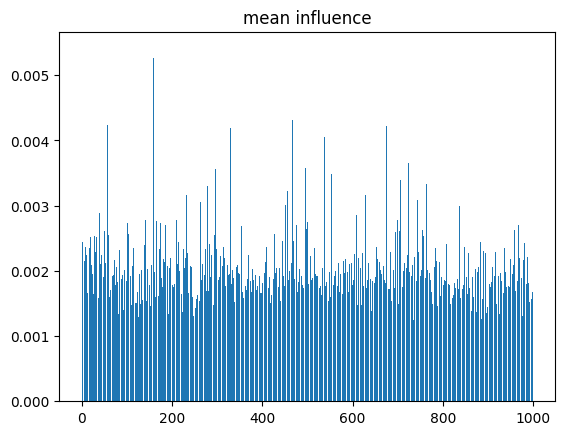

In [7]:
#show shap Values
print("(inputs, Features)")
print(np.shape(shapValues.values))
shap.summary_plot(shapValues)

#create table of maximum influences
featureInfluenceMax = np.zeros(len(shapValues.values[0]))
featureInfluenceMean = np.zeros(len(shapValues.values[0]))
absoluteShapValues = np.abs(shapValues.values)
for i in range(len(absoluteShapValues[0])):
    featureInfluenceMax[i] = np.max(absoluteShapValues[:][i])
    featureInfluenceMean[i] = np.mean(absoluteShapValues[:][i])

plt.bar(range(len(featureInfluenceMax)), featureInfluenceMax)
plt.ylabel("influence")
plt.xlabel("feature")
plt.title("max influence")
plt.show()

plt.bar(range(len(featureInfluenceMean)), featureInfluenceMean)
plt.title("mean influence")
plt.show()


In [34]:
#remove features with low influence
cutoff = 0.2

#create table of maximum influences
featureInfluenceMax = np.zeros(len(shapValues.values[0]))
absoluteShapValues = np.abs(shapValues.values)
for i in range(len(absoluteShapValues[0])):
    featureInfluenceMax[i] = np.max(absoluteShapValues[:][i])

maximum = np.max(featureInfluenceMax)
featureMask = np.zeros(len(featureInfluenceMax))
featureMask[featureInfluenceMax > maximum * cutoff] = 1  

print("will remove " + str(np.count_nonzero(featureMask==0)) + " features out of " + str(len(featureMask)) + ". So " + str(len(featureMask) - np.count_nonzero(featureMask==0)) + " will be left")

optimizedData = data[:, featureMask == 1]

print(np.shape(optimizedData))


will remove 805 features out of 1000. So 195 will be left
(50000, 195)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 100)               19600     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 50)                5050      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_18 (Dense)            (None, 10)                510       
                                                                 
 dense_19 (Dense)            (None, 1)                 11        
                                                                 
Total params: 25171 (98.32 KB)
Trainable params: 25171

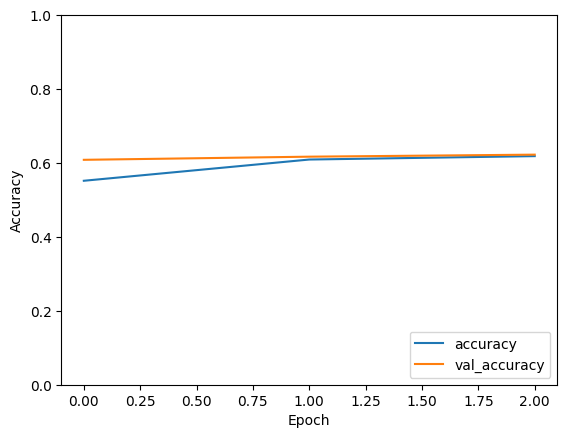

313/313 - 0s - loss: 0.6530 - accuracy: 0.6225 - 186ms/epoch - 593us/step
0.6225000023841858


In [35]:
#create new model
testData = optimizedData[:10000]
testLabels = labels[:10000]
trainData = optimizedData[10000:]
trainLabels = labels[10000:]

newModel = models.Sequential()
#alternate dense connected layers for learning and dropout to prevent overfitting
newModel.add(layers.Dense(100, activation = "relu", input_shape=(len(optimizedData[0]), )))
newModel.add(layers.Dropout(0.30))
newModel.add(layers.Dense(50, activation = "relu"))
newModel.add(layers.Dropout(0.30))
newModel.add(layers.Dense(10, activation = "relu"))
# Output-Layer
newModel.add(layers.Dense(1, activation = "sigmoid"))
newModel.summary()

newModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = newModel.fit(trainData, trainLabels, epochs=3, validation_data=(testData, testLabels))

#set to True to display the changing accuracy of the model during training
if(True):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

#display the accuracy of the trained model
test_loss, test_acc = newModel.evaluate(testData,  testLabels, verbose=2)
print(test_acc)

Model: "sequential_52"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_208 (Dense)           (None, 100)               100100    
                                                                 
 dropout_104 (Dropout)       (None, 100)               0         
                                                                 
 dense_209 (Dense)           (None, 50)                5050      
                                                                 
 dropout_105 (Dropout)       (None, 50)                0         
                                                                 
 dense_210 (Dense)           (None, 10)                510       
                                                                 
 dense_211 (Dense)           (None, 1)                 11        
                                                                 
Total params: 105671 (412.78 KB)
Trainable params: 10

<function matplotlib.pyplot.show(close=None, block=None)>

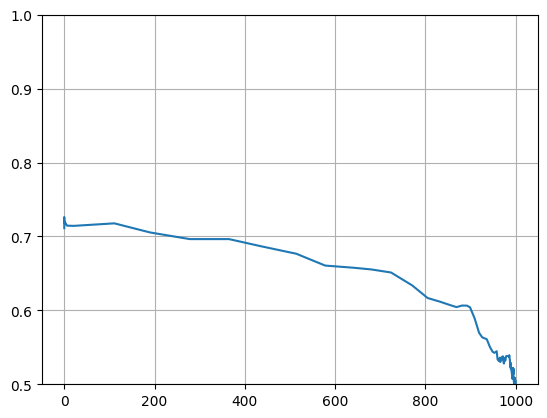

In [12]:
#testing different cutoffs
newModelAccuracies = []
removedFeatures = []

#create table of maximum influences
featureInfluenceMax = np.zeros(len(shapValues.values[0]))
absoluteShapValues = np.abs(shapValues.values)
for i in range(len(absoluteShapValues[0])):
    featureInfluenceMax[i] = np.max(absoluteShapValues[:][i])

for cutoff in range(0, 100):

    #remove features with low influence
    maximum = np.max(featureInfluenceMax)
    featureMask = np.zeros(len(featureInfluenceMax))
    featureMask[featureInfluenceMax > maximum * cutoff/100] = 1  

    #print("will remove " + str(np.count_nonzero(featureMask==0)) + " features out of " + str(len(featureMask)) + ". So " + str(len(featureMask) - np.count_nonzero(featureMask==0)) + " will be left")

    optimizedData = data[:, featureMask == 1]

    #print(np.shape(optimizedData))

    #create new model
    testData = optimizedData[:10000]
    testLabels = labels[:10000]
    trainData = optimizedData[10000:]
    trainLabels = labels[10000:]

    newModel = models.Sequential()
    #alternate dense connected layers for learning and dropout to prevent overfitting
    newModel.add(layers.Dense(100, activation = "relu", input_shape=(len(optimizedData[0]), )))
    newModel.add(layers.Dropout(0.30))
    newModel.add(layers.Dense(50, activation = "relu"))
    newModel.add(layers.Dropout(0.30))
    newModel.add(layers.Dense(10, activation = "relu"))
    # Output-Layer
    newModel.add(layers.Dense(1, activation = "sigmoid"))
    newModel.summary()

    newModel.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    history = newModel.fit(trainData, trainLabels, epochs=3, validation_data=(testData, testLabels))

    #display the accuracy of the trained model
    test_loss, test_acc = newModel.evaluate(testData,  testLabels, verbose=0)
    newModelAccuracies.append(test_acc)
    removedFeatures.append(np.count_nonzero(featureMask==0))

plt.plot(removedFeatures, newModelAccuracies)
plt.ylim(0.5, 1)
plt.grid(which = "both", visible = True)
plt.show


In [ ]:
#complete function
#needs to be tested
def getNewDataset(model, trainingData, explanationData, cutoff):
    #getting the SHAP values

    #creating a masker (a permutated dataset to train the explainer on)
    masker = shap.maskers.Independent(data = trainingData)
    #create the explainer and get the shap-values
    explainer = shap.explainers.Permutation(model, masker = masker, max_evals = 2*len(data) + 10)
    shapValues = explainer(explanationData)

    #create table of maximum influences
    featureInfluenceMax = np.zeros(len(shapValues.values[0]))
    absoluteShapValues = np.abs(shapValues.values)
    for i in range(len(absoluteShapValues[0])):
        featureInfluenceMax[i] = np.max(absoluteShapValues[:][i])

    maximum = np.max(featureInfluenceMax)
    featureMask = np.zeros(len(featureInfluenceMax))
    featureMask[featureInfluenceMax > maximum * cutoff] = 1  

    print("will remove " + str(np.count_nonzero(featureMask==0)) + " features out of " + str(len(featureMask)) + ". So " + str(len(featureMask) - np.count_nonzero(featureMask==0)) + " will be left")

    optimizedData = explanationData[:, featureMask == 1]
    return(optimizedData)